In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('abs_path_to_the_current_project')
from performance import PerformanceCOCOA
import numpy as np
import matplotlib.pyplot as plt
import uproot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
inf_path = 'path_to_test_pred_merged.root'

In [4]:
performance = PerformanceCOCOA(inf_path, res_factor=2)

computing ensemble average: 100%|██████████| 10000/10000 [00:00<00:00, 10957.39it/s]


### global settings and helper functions

In [5]:
FIG_WIDTH = 10
FONTSIZE = 14
FONTSIZE_LATEX = 20
FONTSIZE_LEGEND = 12

TR_COLOR = (0.7, 0.7, 0.7)
LR_COLOR = 'royalblue'
LR_COLOR_FILL = 'cornflowerblue'
HR_COLOR = (0.67, 0.31, 0.39)
HR_COLOR_FILL = (0.96, 0.44, 0.56)

In [65]:
# def get_label(x):
#     _mean = np.mean(x)
#     _std = np.std(x)

#     return f'$\mu$ = {_mean:>5.4f}, $\sigma$ = {_std:>3.4f}'


def get_label(x, decimal_places=2):
    _mean = np.mean(x)
    _std = np.std(x)
    mean_format = f'{{:>{2}.{decimal_places}f}}'
    std_format = f'{{:>{2}.{decimal_places}f}}'

    return f'$\mu$ = {mean_format.format(_mean)}, $\sigma$ = {std_format.format(_std)}'

# Summary plots

In [10]:
ensemble_size_dict = {}
for n in [2, 5, 10, 25, 50, 100]:
    ensemble_size_dict[n] = performance.compute_ensemble_average(n)

### Residual energy distributions
- Residual distributions comparing LR (measured) and HR (predicted)


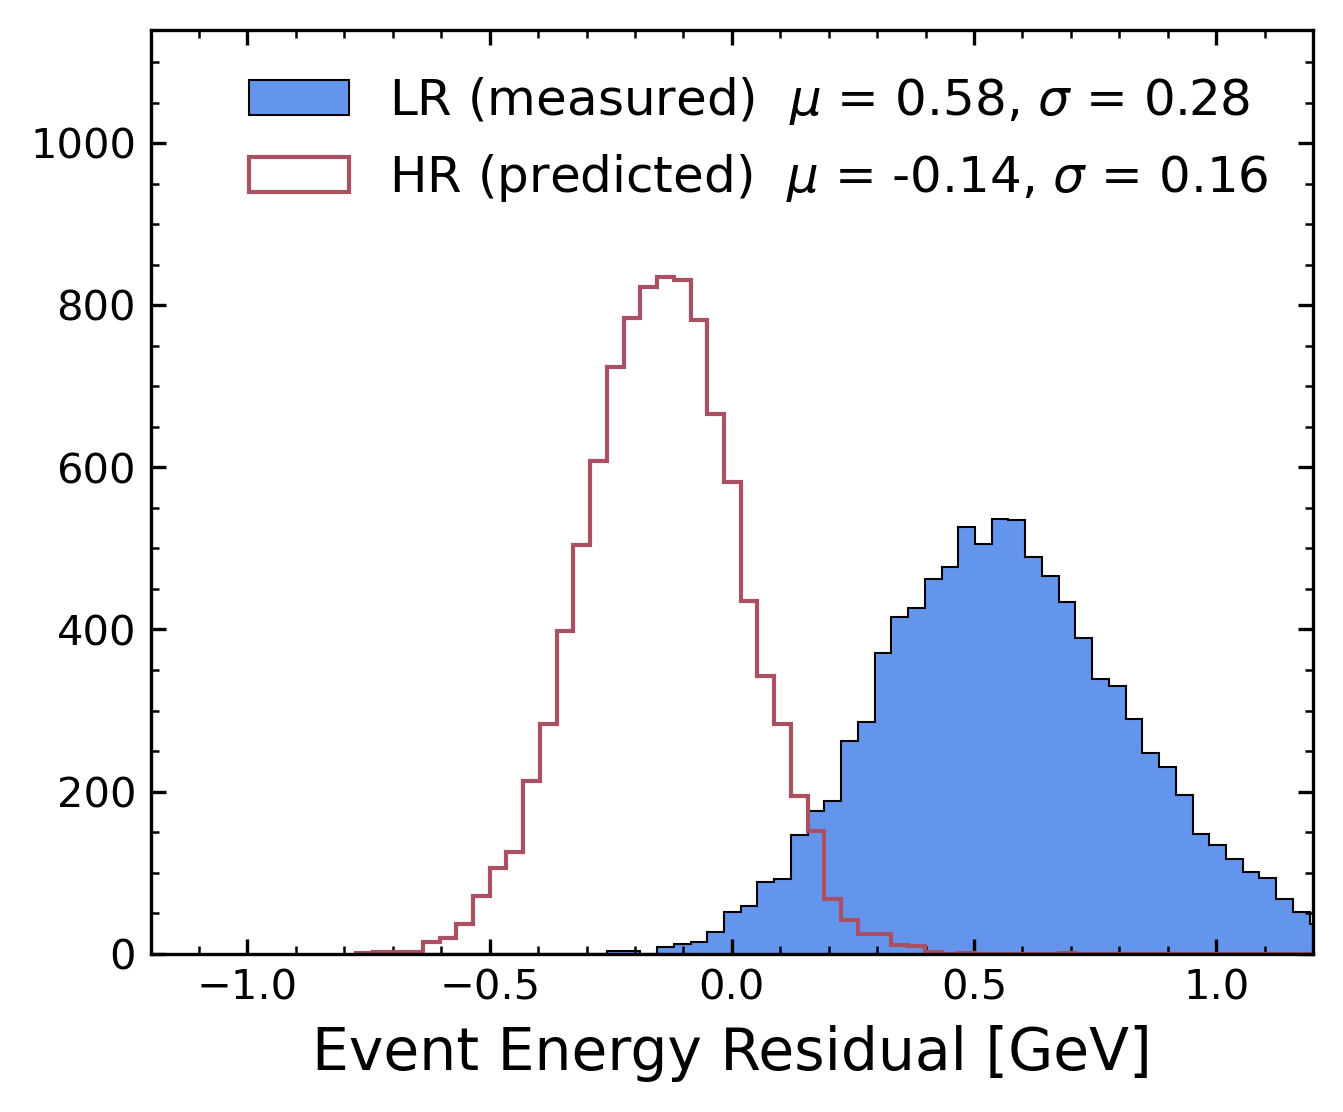

In [66]:
n_row, n_col = 1, 1

fig = plt.figure(figsize=(FIG_WIDTH/2, 0.8*FIG_WIDTH/2), dpi=300)
gs = fig.add_gridspec(n_row, n_col)

_event_energy_hr_truth = np.array([x.sum() for x in performance.high_e_truth]) * 1e-3
_event_energy_lr_meas = np.array([x.sum() for x in performance.low_e_measured]) * 1e-3
# _event_energy_hr_pred = np.array([x.sum() for x in performance.high_e_pred]) * 1e-3
_event_energy_hr_pred_ens10 = np.array([x.sum() for x in ensemble_size_dict[10]]) * 1e-3

_lr_res = (_event_energy_lr_meas - _event_energy_hr_truth) # / _event_energy_hr_truth
# _hr_res = (_event_energy_hr_pred - _event_energy_hr_truth) # / _event_energy_hr_truth
_hr_res = (_event_energy_hr_pred_ens10 - _event_energy_hr_truth) # / _event_energy_hr_truth

_lr_rel_res = _lr_res / _event_energy_hr_truth
_hr_rel_res = _hr_res / _event_energy_hr_truth

bins = np.linspace(min(np.min(_lr_res), np.min(_hr_res)), max(np.max(_lr_res), np.max(_hr_res)), 80)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(_lr_res, bins=bins, histtype='stepfilled', color=LR_COLOR_FILL, 
    label='LR (measured)  ' + get_label(_lr_res), ec='black', lw=0.5) # zorder=5, 
ax1.hist(_hr_res, bins=bins, histtype='step', color=HR_COLOR, 
    label='HR (predicted)  ' + get_label(_hr_res)) # , zorder=10)
# ax1.grid(True, which='both', linestyle='-', lw=0.3)

ax1.legend(loc='upper right', fontsize=FONTSIZE_LEGEND, frameon=False)
ax1.set_ylim(0, ax1.get_ylim()[1] * 1.3)
ax1.set_xlabel('Event Energy Residual [GeV]', fontsize=FONTSIZE)
ax1.set_xlim(-1.2, 1.2)

ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top=True, left=True, right=True)

### Effect of Ensemble size

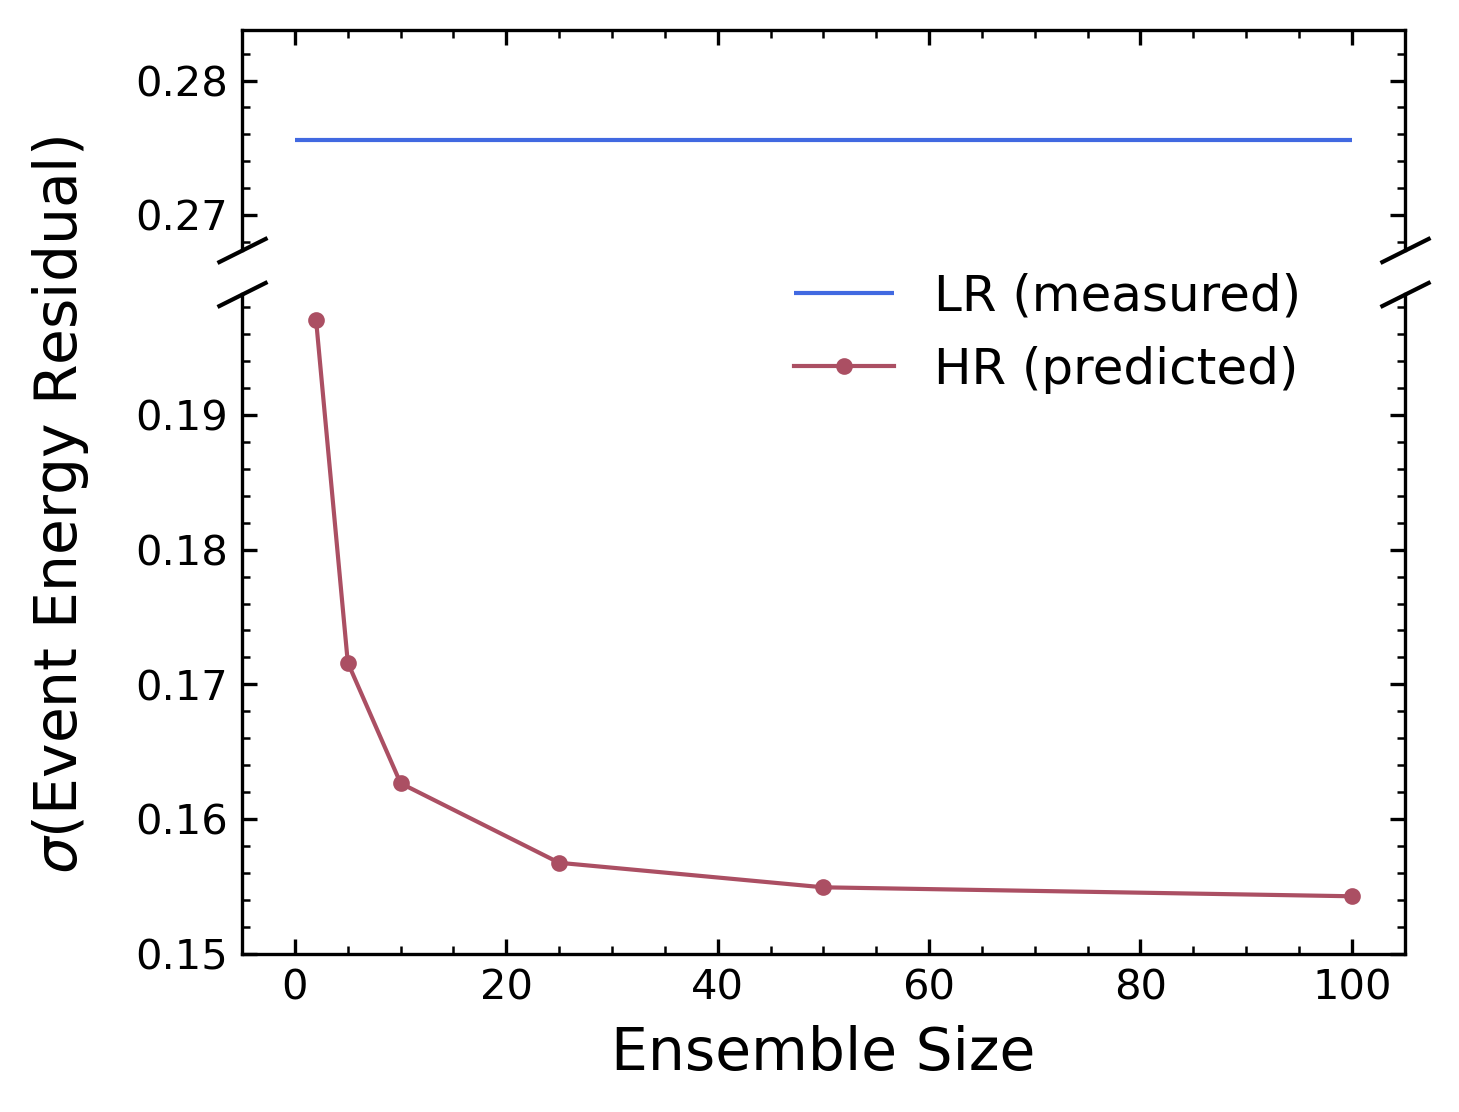

In [67]:
n_row, n_col = 2, 1

fig = plt.figure(figsize=(FIG_WIDTH/2, 0.8*FIG_WIDTH/2), dpi=300)
gs = fig.add_gridspec(n_row, n_col, height_ratios=[1, 3], hspace=0.1)

_x_vals, _y_vals = [], []
for ens_i, (k, v) in enumerate(ensemble_size_dict.items()):
    res = []; rel_res = []
    for ev_i in range(performance.n_events):
        res_ev = v[ev_i].sum() - performance.high_e_truth[ev_i].sum()
        rel_res_ev = res_ev / performance.high_e_truth[ev_i].sum()
        res.append(res_ev * 1e-3)
        rel_res.append(rel_res_ev)
    
    _x_vals.append(k)
    _y_vals.append(np.std(res))

# lr plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top=True, left=True, right=True)

# hr plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.hlines(np.std(_lr_res), 0, 100, color=LR_COLOR, lw=1.0, label='LR (measured)')
ax2.plot(_x_vals, _y_vals, marker='o', color=HR_COLOR, lw=1.0, markersize=3, label='HR (predicted)')
ax2.set_xlabel('Ensemble Size', fontsize=FONTSIZE)
ax2.set_ylabel('$\sigma \\left( \\right.$Event Energy Residual$\\left. \\right) $', fontsize=FONTSIZE)
ax2.yaxis.set_label_coords(-0.13, 0.68)
# ax2.grid(True, which='major', linestyle='-', lw=0.5)
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', top=True, left=True, right=True)
ax2.legend(loc='upper right', fontsize=FONTSIZE_LEGEND, frameon=False, bbox_to_anchor=(0.95, 1.1))

# plot in both axes for legend
for ax in [ax1, ax2]:
    ax.hlines(np.std(_lr_res), 0, 100, color=LR_COLOR, lw=1.0, label='LR (measured)')

# ylim adjustment
ax2.set_ylim(0.15, 0.199)
ax1_h = (ax2.get_ylim()[1] - ax2.get_ylim()[0]) / 6
ax1.set_ylim(np.std(_lr_res) - ax1_h, np.std(_lr_res) + ax1_h)

# copy-pasted from mpl docs
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

## Relative residual

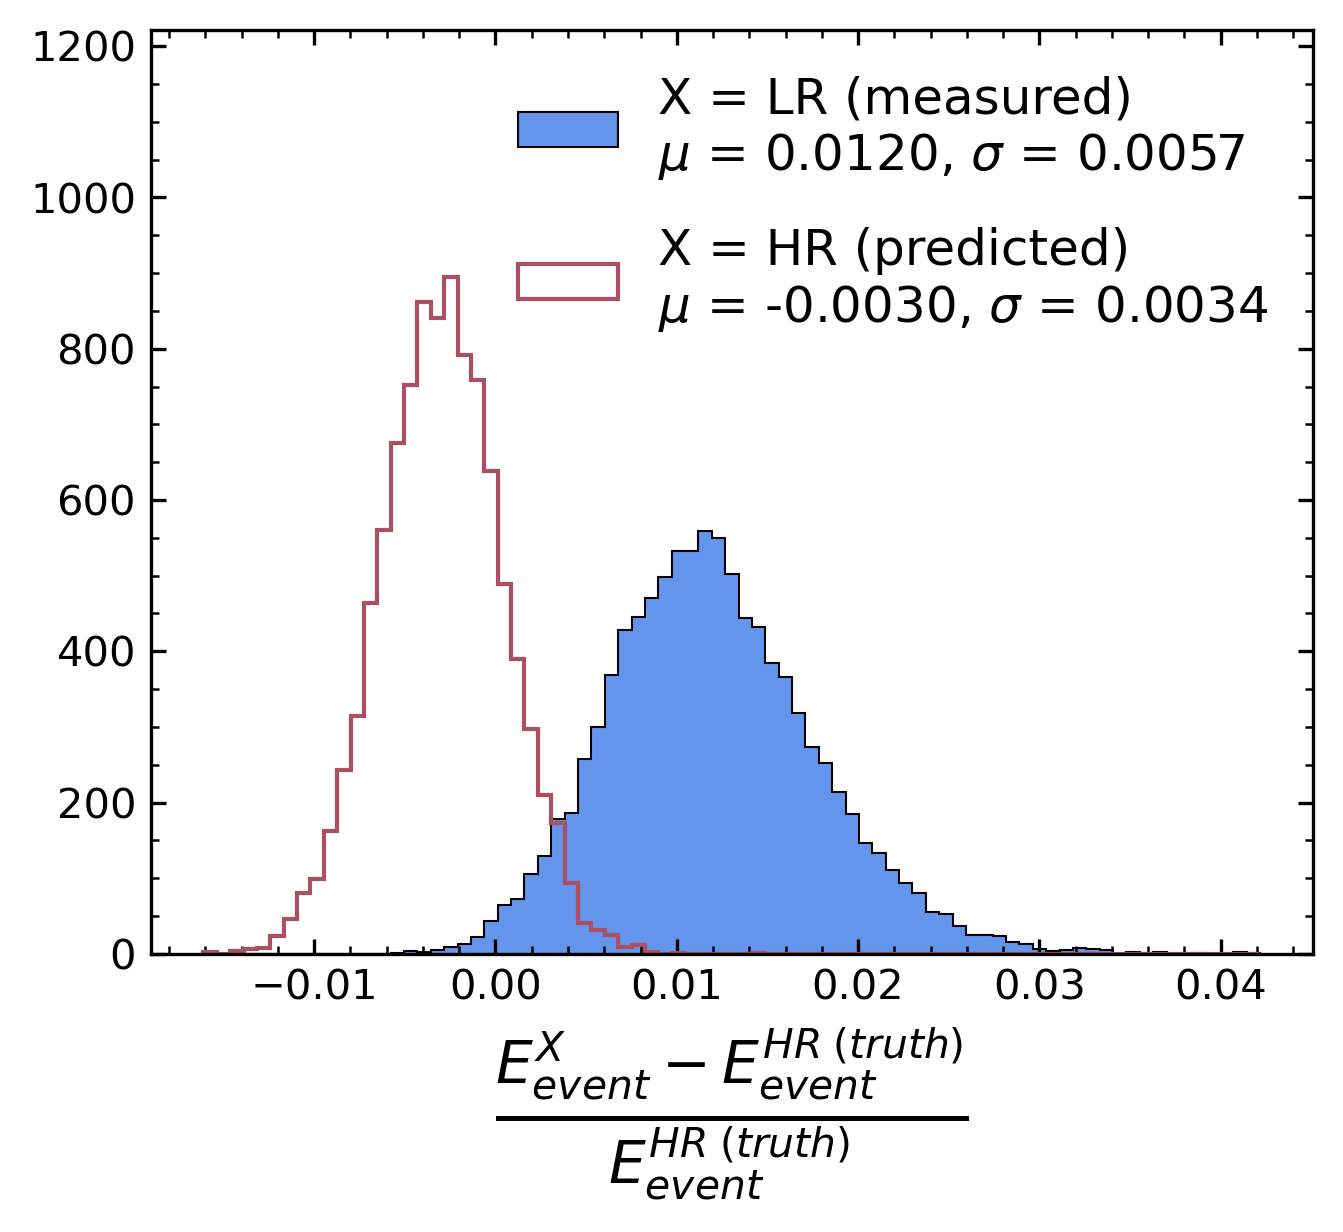

In [99]:
n_row, n_col = 1, 1

fig = plt.figure(figsize=(FIG_WIDTH/2, 0.8*FIG_WIDTH/2), dpi=300)
gs = fig.add_gridspec(n_row, n_col)

_lr_rel_res = _lr_res / _event_energy_hr_truth
_hr_rel_res = _hr_res / _event_energy_hr_truth

bins = np.linspace(min(np.min(_lr_rel_res), np.min(_hr_rel_res)), max(np.max(_lr_rel_res), np.max(_hr_rel_res)), 80)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(_lr_rel_res, bins=bins, histtype='stepfilled', color=LR_COLOR_FILL, 
    label='X = LR (measured) \n' + get_label(_lr_rel_res, decimal_places=4), ec='black', lw=0.5) # zorder=5, 
ax1.hist(_hr_rel_res, bins=bins, histtype='step', color=HR_COLOR, 
    label='X = HR (predicted) \n' + get_label(_hr_rel_res, decimal_places=4)) # , zorder=10)
# ax1.grid(True, which='both', linestyle='-', lw=0.3)

ax1.legend(loc='upper right', fontsize=FONTSIZE_LEGEND, frameon=False, labelspacing=0.9)
ax1.set_ylim(0, ax1.get_ylim()[1] * 1.3)
ax1.set_xlabel('$\\frac{E_{event}^{X} - E_{event}^{HR \\; (truth)}}{E_{event}^{HR \\; (truth)}}$', fontsize=FONTSIZE_LATEX)

# ax1.set_xlabel('Event Energy Relatve Residual', fontsize=FONTSIZE)

ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top=True, left=True, right=True)

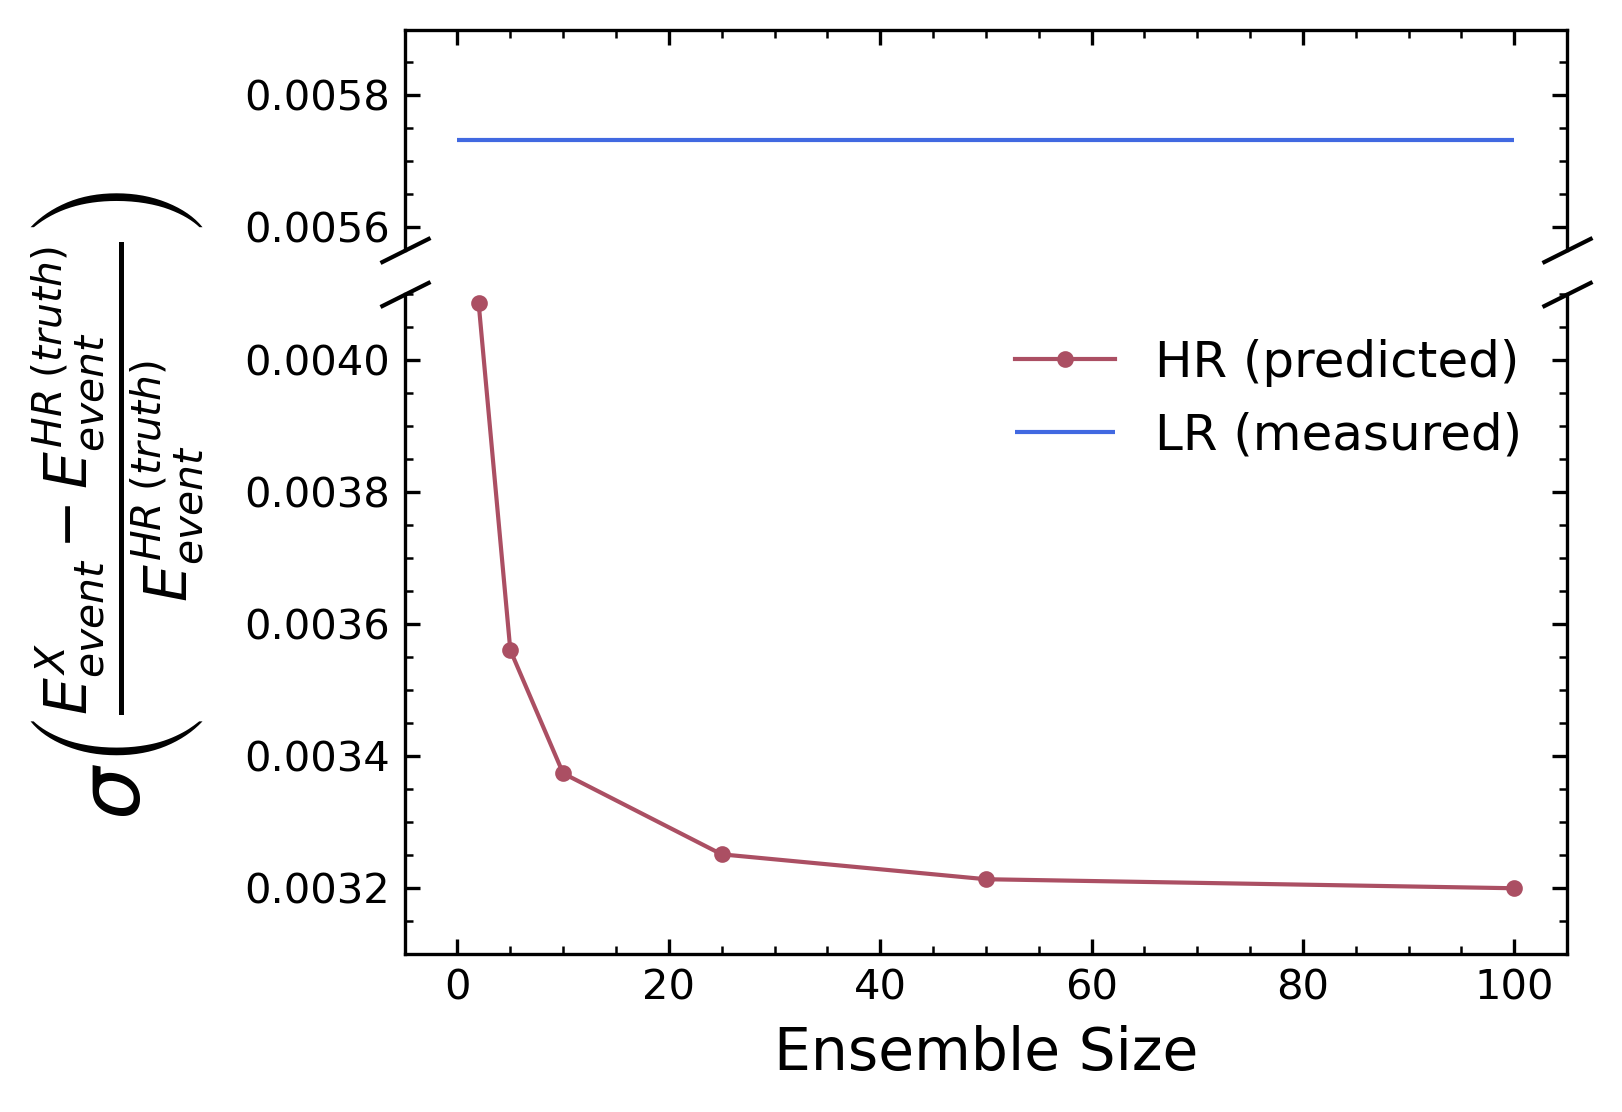

In [98]:
n_row, n_col = 2, 1

fig = plt.figure(figsize=(FIG_WIDTH/2, 0.8*FIG_WIDTH/2), dpi=300)
gs = fig.add_gridspec(n_row, n_col, height_ratios=[1, 3], hspace=0.1)

_x_vals, _y_vals = [], []
for ens_i, (k, v) in enumerate(ensemble_size_dict.items()):
    res = []; rel_res = []
    for ev_i in range(performance.n_events):
        res_ev = v[ev_i].sum() - performance.high_e_truth[ev_i].sum()
        rel_res_ev = res_ev / performance.high_e_truth[ev_i].sum()
        res.append(res_ev * 1e-3)
        rel_res.append(rel_res_ev)
    
    _x_vals.append(k)
    _y_vals.append(np.std(rel_res))

# lr plot
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, left=True, right=True)

# hr plot
ax2.plot(_x_vals, _y_vals, marker='o', color=HR_COLOR, lw=1.0, markersize=3, label='HR (predicted)')

# plot in both axes for legend
for ax in [ax1, ax2]:
    ax.hlines(np.std(_lr_rel_res), 0, 100, color=LR_COLOR, lw=1.0, label='LR (measured)')

# ax2 cosmetics
ax2.set_xlabel('Ensemble Size', fontsize=FONTSIZE)
# ax2.set_ylabel('$\sigma \\left( \\right.$Event Energy Residual$\\left. \\right) $', fontsize=FONTSIZE)
ax2.set_ylabel('$\sigma \\left( \\frac{E_{event}^{X} - E_{event}^{HR \\; (truth)}}{E_{event}^{HR \\; (truth)}} \\right) $', fontsize=FONTSIZE_LATEX)

ax2.yaxis.set_label_coords(-0.17, 0.68)
ax2.legend(loc='upper right', fontsize=FONTSIZE_LEGEND, frameon=False) #, bbox_to_anchor=(0.95, 1.1))

# ylim adjustment
ax2.set_ylim(0.0031, 0.0041)
ax1_h = (ax2.get_ylim()[1] - ax2.get_ylim()[0]) / 6
ax1.set_ylim(np.std(_lr_rel_res) - ax1_h, np.std(_lr_rel_res) + ax1_h)

# copy-pasted from mpl docs
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

### Substructure plots

In [31]:
fp_sub = 'substructures.root'

tree = uproot.open(fp_sub)['substructures']

c2_low = tree['c2_low'].array(library='np')
c3_low = tree['c3_low'].array(library='np')
d2_low = tree['d2_low'].array(library='np')

c2_low_split = tree['c2_low_split'].array(library='np')
c3_low_split = tree['c3_low_split'].array(library='np')
d2_low_split = tree['d2_low_split'].array(library='np')

c2_high_truth = tree['c2_high_truth'].array(library='np')
c3_high_truth = tree['c3_high_truth'].array(library='np')
d2_high_truth = tree['d2_high_truth'].array(library='np')

c2_high_pred = tree['c2_high_pred'].array(library='np')
c3_high_pred = tree['c3_high_pred'].array(library='np')
d2_high_pred = tree['d2_high_pred'].array(library='np')

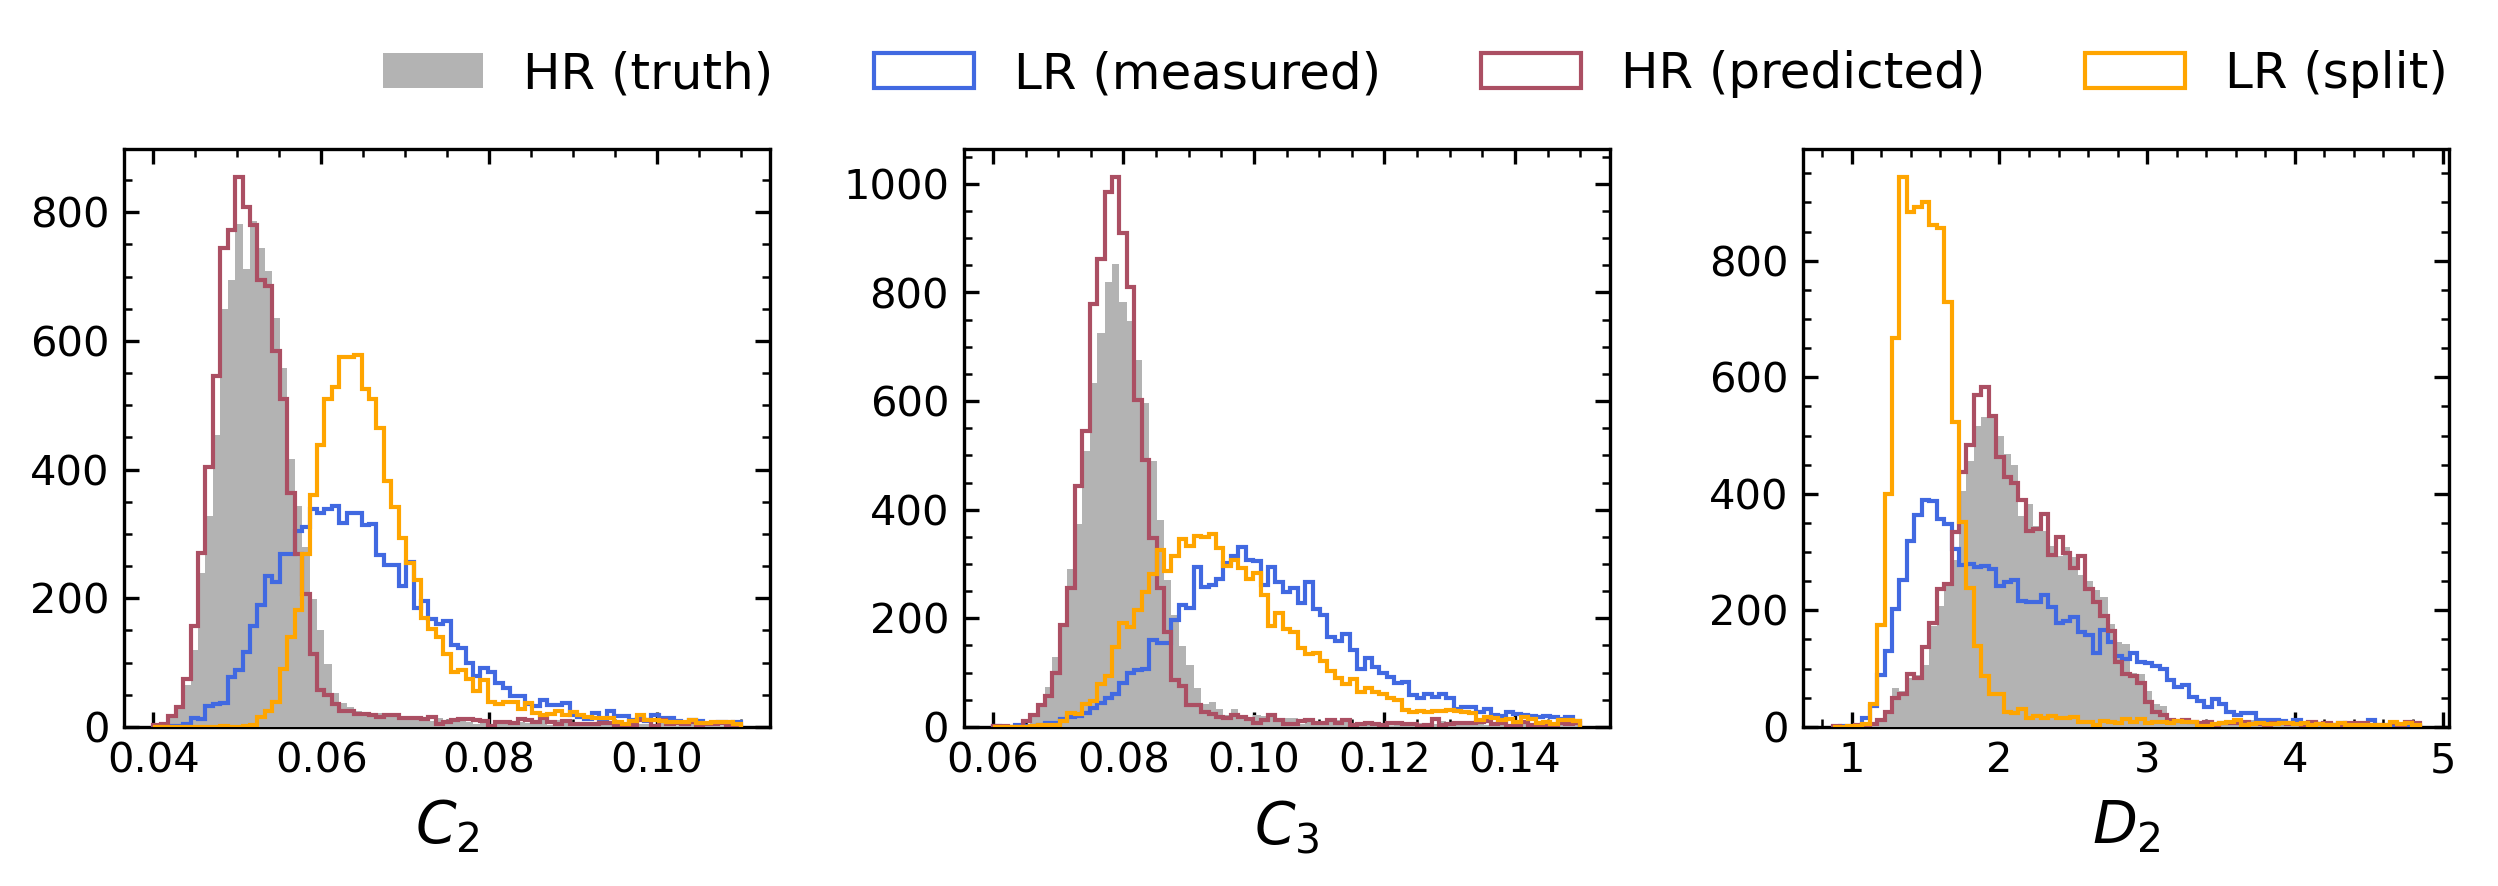

In [32]:
n_row, n_col = 1, 3

fig = plt.figure(figsize=(FIG_WIDTH, 0.25 * FIG_WIDTH), dpi=300)
gs = fig.add_gridspec(1, 3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
comb = np.concatenate([c2_high_truth, c2_low, c2_high_pred, c2_low_split])
_min, _max = 0.04, 0.11 # np.percentile(comb, 0), np.percentile(comb, 95)
bins = np.linspace(_min, _max, 80)
ax1.hist(c2_high_truth, bins=bins, histtype='stepfilled', color=TR_COLOR, label='HR (truth)', alpha=1.0, zorder=10)
ax1.hist(c2_low, bins=bins, histtype='step', color=LR_COLOR, label='LR (measured)', zorder=10)
ax1.hist(c2_high_pred, bins=bins, histtype='step', color=HR_COLOR, label='HR (predicted)', zorder=10)
ax1.hist(c2_low_split, bins=bins, histtype='step', color='orange', label='LR (split)', zorder=10)
ax1.set_xlabel('$C_2$', fontsize=FONTSIZE)

ax2 = fig.add_subplot(gs[0, 1])
comb = np.concatenate([c3_high_truth, c3_low, c3_high_pred, c3_low_split])
_min, _max = 0.06, 0.15 # np.percentile(comb, 0), np.percentile(comb, 95)
bins = np.linspace(_min, _max, 80)
ax2.hist(c3_high_truth, bins=bins, histtype='stepfilled', color=TR_COLOR, label='HR (truth)', alpha=1.0, zorder=10)
ax2.hist(c3_low, bins=bins, histtype='step', color=LR_COLOR, label='LR (measured)', zorder=10)
ax2.hist(c3_high_pred, bins=bins, histtype='step', color=HR_COLOR, label='HR (predicted)', zorder=10)
ax2.hist(c3_low_split, bins=bins, histtype='step', color='orange', label='LR (split)', zorder=10)
ax2.set_xlabel('$C_3$', fontsize=FONTSIZE)

ax3 = fig.add_subplot(gs[0, 2])
comb = np.concatenate([d2_high_truth, d2_low, d2_high_pred, d2_low_split])
_min, _max = np.percentile(comb, 0), np.percentile(comb, 95)
bins = np.linspace(_min, _max, 80)
ax3.hist(d2_high_truth, bins=bins, histtype='stepfilled', color=TR_COLOR, label='HR (truth)', alpha=1.0, zorder=10)
ax3.hist(d2_low, bins=bins, histtype='step', color=LR_COLOR, label='LR (measured)', zorder=10)
ax3.hist(d2_high_pred, bins=bins, histtype='step', color=HR_COLOR, label='HR (predicted)', zorder=10)
ax3.hist(d2_low_split, bins=bins, histtype='step', color='orange', label='LR (split)', zorder=10)
ax3.set_xlabel('$D_2$', fontsize=FONTSIZE)


# legend outside ax3
# ax3.legend(loc='upper center', bbox_to_anchor=(-0.25, 1.25), ncol=3, fontsize=FONTSIZE_LEGEND, frameon=False)
ax3.legend(loc='upper center', bbox_to_anchor=(-0.6, 1.25), ncol=4, fontsize=FONTSIZE_LEGEND, frameon=False)

for ax in [ax1, ax2, ax3]:
    # ax.grid(True, which='both', linestyle='-', lw=0.3)
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, left=True, right=True)